In [1]:
import scipy.io as spio
import numpy as np

X = spio.loadmat(file_name='../data/bci-sample-data/x.mat')

Y = spio.loadmat(file_name='../data/bci-sample-data/y.mat')

Data = X['Intensification_Data']
SType = Y['Intensification_SType'].mean(axis=1)

(Data.shape, SType.shape, Data.dtype, SType.dtype)

# 30 % total data test
# 70 % total data train+valid
length = int(Data.shape[0] * 0.30)
length

TrainDataAll = Data[:-length]
TestData = Data[-length:]

TrainDataAll.shape, TestData.shape

# 30% total train data is valid
# 70% total trainALl is training
length2 = int(TrainDataAll.shape[0] * 0.30)
length2

TrainData = TrainDataAll[:-length2]
ValidData = TrainDataAll[-length2:]

TrainData.shape, ValidData.shape

# Normalizing input data
def normalize(inputs):
    return (inputs - inputs.mean(axis=0)[None,:,:]) / inputs.std(axis=0)[None,:,:]

# onehot vectorizing output labels
def one_hot(labels, n_class):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

# get minibatches for learning
def get_batches(X, y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

# Standardize/normalize train and test
X_train_norm = normalize(inputs=TrainData)
X_valid_norm = normalize(inputs=ValidData)
X_test_norm = normalize(inputs=TestData)

(X_train_norm.shape, X_train_norm.dtype, 
X_valid_norm.shape, X_valid_norm.dtype,
X_test_norm.shape, X_test_norm.dtype)

LabelsAll = SType[:]
TrainLabelsAll = SType[:-length]
TestLabels = SType[-length:]

LabelsAll.shape, TrainLabelsAll.shape, TestLabels.shape

TrainLabels = TrainLabelsAll[:-length2]
ValidLabels = TrainLabelsAll[-length2:]

TrainLabels.shape, ValidLabels.shape

Y_train = np.array(TrainLabels, dtype=int)
Y_valid = np.array(ValidLabels, dtype=int)
Y_test = np.array(TestLabels, dtype=int)

(Y_train.shape, Y_train.dtype, 
Y_test.shape, Y_test.dtype,
Y_valid.shape, Y_valid.dtype)

### Hyperparameters

# CNN hyper parameters
# Input data
batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial

# Output labels
n_classes = int(LabelsAll.max() + 1)

# Tweekable parameters
learning_rate = 0.001 #1e-3
epochs = 1 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

Y_train_onehot = one_hot(labels=Y_train, n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid, n_class=n_classes)
Y_test_onehot = one_hot(labels=Y_test, n_class=n_classes)

(Y_train_onehot.shape, Y_valid_onehot.shape, Y_test_onehot.shape,
 X_train_norm.shape, X_valid_norm.shape, X_test_norm.shape)

# GPUs availability or CPU

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

#  No graphs is needed on tensorflow
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [2]:
# (batch, 192, 64) --> (batch, 94, 128)
# (192 - 6 + 0)/2 + 1 = (186/2)+1= 93+1= 94
# (2/6)==(1/3) with strides/kernel_size is 33.333% non-overlap/diff region and 
# 66.666% overlapping window/ common region
in_conv = inputs_
out_conv = tf.layers.conv1d(inputs=in_conv, filters=128, kernel_size=6, strides=2, padding='valid')
out_conv = tf.layers.batch_normalization(inputs=out_conv)
out_conv = tf.nn.relu(features=out_conv)
out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(out_conv.shape)

# (batch, 94, 128) --> (batch, 45, 256)
# (94 - 6 + 0)/2 + 1 = (88/2)+1= 44+1= 45
# (2/6)==(1/3) with strides/kernel_size is 33.333% non-overlap/diff region and 
# 66.666% overlapping window/ common region
in_conv = out_conv
out_conv = tf.layers.conv1d(inputs=in_conv, filters=256, kernel_size=6, strides=2, padding='valid')
out_conv = tf.layers.batch_normalization(inputs=out_conv)
out_conv = tf.nn.relu(features=out_conv)
out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(out_conv.shape)

(?, 94, 128)
(?, 45, 256)


In [3]:
#  This functions very similar to embedding
print(out_conv.shape)
lstm_in = tf.transpose(out_conv, [1,0,2]) # reshape into (seq_len, N, channels)
print(lstm_in.shape)
lstm_in = tf.reshape(lstm_in, [-1, 256]) # Now (seq_len*N, n_channels)
print(lstm_in.shape)

# To cells
lstm_size = 256*3 # 3 times the amount of channels
print(lstm_size)
lstm_layers = 1        # Number of layers
lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
print(lstm_in.shape)

# Open up the tensor into a list of seq_len pieces
lstm_in = tf.split(lstm_in, 45, 0)
print(len(lstm_in))

(?, 45, 256)
(45, ?, 256)
(?, 256)
768
(?, 768)
45


In [4]:
# Add LSTM layers
# lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
lstm = tf.nn.rnn_cell.BasicLSTMCell(lstm_size)
print(lstm)
# drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
drop = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
print(drop)
# cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
cell = tf.nn.rnn_cell.MultiRNNCell([drop] * lstm_layers)
print(cell)
initial_state = cell.zero_state(batch_size, tf.float32)
print(initial_state)

(LSTMStateTuple(c=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros:0' shape=(31, 768) dtype=float32>, h=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros_1:0' shape=(31, 768) dtype=float32>),)


In [5]:
# Reuse should be activated
#  NOTE: should be run ONCE
# Remember the inputs are usually embedded input or texts
# outputs, final_state = tf.contrib.rnn.static_rnn(cell=cell, inputs=lstm_in, dtype=tf.float32, 
#                                                  initial_state = initial_state)
outputs, final_state = tf.nn.static_rnn(cell=cell, inputs=lstm_in, dtype=tf.float32,
                                        initial_state = initial_state)
# outputs, final_state = tf.nn.dynamic_rnn(cell, lstm_in, dtype=tf.float32, 
#                                          initial_state=initial_state)# print(outputs, final_state)

In [6]:
# We only need the last output tensor to pass into a classifier
logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
print(logits, outputs[-1])

Tensor("logits/BiasAdd:0", shape=(31, 2), dtype=float32) Tensor("rnn/rnn/multi_rnn_cell/cell_0_44/dropout/mul:0", shape=(31, 768), dtype=float32)


In [7]:
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [8]:
# Plotting the acc and loss curve
train_acc = []
train_loss = []

valid_acc = []
valid_loss = []

with tf.Session() as sess:
    # initalize session global variables just in the case they are initialized.
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            # Feed dictionary
            feed = {inputs_:x, labels_:y, keep_prob_: keep_prob, initial_state:state, 
                    learning_rate_:learning_rate}
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], feed_dict = feed)
            
            train_acc.append(acc)
            train_loss.append(loss)
            
            ################################ Validation
            # Initialize 
            state_v = sess.run(cell.zero_state(batch_size, tf.float32))
            loss_v_batch, acc_v_batch = [], []

            # Loop over batches
            for x_v, y_v in get_batches(X_valid_norm, Y_valid_onehot, batch_size):

                # Feed dictionary
                feed = {inputs_:x_v, labels_:y_v, keep_prob_: 1.0, initial_state:state_v}
                loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                
                acc_v_batch.append(acc_v)
                loss_v_batch.append(loss_v)
                
            valid_acc.append(np.mean(acc_v_batch))
            valid_loss.append(np.mean(loss_v_batch))
            
            # Print info
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Train loss: {:6f}".format(loss),
                  "Valid loss: {:.6f}".format(np.mean(valid_loss)),
                  "Train acc: {:6f}".format(acc),
                  "Valid acc: {:.6f}".format(np.mean(valid_acc)))
            
    ################################ Test
    # Initialize 
    state = sess.run(initial_state)
    acc_batch, loss_batch = [], []

    # Loop over batches
    for x, y in get_batches(X_test_norm, Y_test_onehot, batch_size):

        # Feed dictionary
        feed = {inputs_:x, labels_:y, keep_prob_:1.0, initial_state:state}
        loss, state, acc = sess.run([cost, final_state, accuracy], feed_dict = feed)

        acc_batch.append(acc)
        loss_batch.append(loss)

    # Print info
    print("Epoch: {}/{}".format(e+1, epochs),
          "Test loss: {:6f}".format(np.mean(loss_batch)),
          "Test acc: {:6f}".format(np.mean(acc_batch)))

Epoch: 1/1 Train loss: 0.574598 Valid loss: 1.244997 Train acc: 0.677419 Valid acc: 0.833458
Epoch: 1/1 Train loss: 2.184949 Valid loss: 0.942520 Train acc: 0.806452 Valid acc: 0.833458
Epoch: 1/1 Train loss: 1.013215 Valid loss: 1.012552 Train acc: 0.806452 Valid acc: 0.612153
Epoch: 1/1 Train loss: 1.422072 Valid loss: 0.877176 Train acc: 0.129032 Valid acc: 0.667479
Epoch: 1/1 Train loss: 0.529491 Valid loss: 0.803170 Train acc: 0.806452 Valid acc: 0.700675
Epoch: 1/1 Train loss: 0.440027 Valid loss: 0.760059 Train acc: 0.870968 Valid acc: 0.722806
Epoch: 1/1 Train loss: 0.633618 Valid loss: 0.726143 Train acc: 0.806452 Valid acc: 0.738613
Epoch: 1/1 Train loss: 0.615665 Valid loss: 0.694865 Train acc: 0.806452 Valid acc: 0.750469
Epoch: 1/1 Train loss: 0.472639 Valid loss: 0.667819 Train acc: 0.838710 Valid acc: 0.759690
Epoch: 1/1 Train loss: 0.381802 Valid loss: 0.647318 Train acc: 0.838710 Valid acc: 0.766542
Epoch: 1/1 Train loss: 0.424399 Valid loss: 0.631218 Train acc: 0.8709

Epoch: 1/1 Train loss: 0.469144 Valid loss: 0.480888 Train acc: 0.838710 Valid acc: 0.825915
Epoch: 1/1 Train loss: 0.419797 Valid loss: 0.480559 Train acc: 0.838710 Valid acc: 0.825998
Epoch: 1/1 Train loss: 0.466861 Valid loss: 0.480239 Train acc: 0.838710 Valid acc: 0.826079
Epoch: 1/1 Train loss: 0.524733 Valid loss: 0.479927 Train acc: 0.838710 Valid acc: 0.826158
Epoch: 1/1 Train loss: 0.400694 Valid loss: 0.479638 Train acc: 0.870968 Valid acc: 0.826236
Epoch: 1/1 Train loss: 0.548851 Valid loss: 0.479358 Train acc: 0.806452 Valid acc: 0.826312
Epoch: 1/1 Train loss: 0.411343 Valid loss: 0.479089 Train acc: 0.838710 Valid acc: 0.826386
Epoch: 1/1 Train loss: 0.449335 Valid loss: 0.478828 Train acc: 0.838710 Valid acc: 0.826459
Epoch: 1/1 Train loss: 0.474604 Valid loss: 0.478570 Train acc: 0.838710 Valid acc: 0.826531
Epoch: 1/1 Train loss: 0.488982 Valid loss: 0.478308 Train acc: 0.806452 Valid acc: 0.826600
Epoch: 1/1 Train loss: 0.499544 Valid loss: 0.478043 Train acc: 0.8387

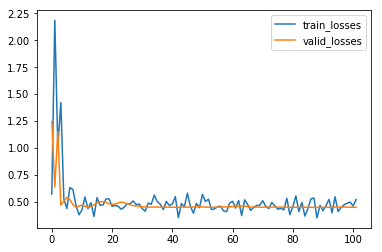

In [9]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='train_losses')
mplot.plot(valid_loss, label='valid_losses')
mplot.legend()
mplot.show()

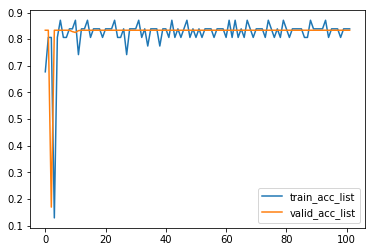

In [10]:
# import matplotlib.pyplot as mplot

mplot.plot(train_acc, label='train_acc_list')
mplot.plot(valid_acc, label='valid_acc_list')
mplot.legend()
mplot.show()